In [1]:
import cv2               #for image read, flip, crop etc
import csv               #for csv file operation
import numpy as np       #for numpy array operation
import os                #for directory operation
import sklearn           #for yield, util etc
from sklearn.model_selection import train_test_split    # split train test data

#for model
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def _getLinesFromDrivingLogs(imagepath):
    lines = []
    with open(imagepath + '/driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
def _getRelativeImagePath(dataPath, line):
    """
    @description:      This module gets relative image path from absolution path
    @param line:       line read from driving log csv
    @return newLine:   new line with relative path
    @example input:    /Users/udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_12_02_17_49_38_331.jpg
    @example output:   ./data/IMG/center_2017_12_02_17_49_38_331.jpg
    """
    source_path = line
    filename = source_path.split('/')[-1]
    newLine = dataPath +'/IMG/'+filename.strip()
    return newLine

In [4]:
def getdata(imagepath):
    dirc = [x[0] for x in os.walk(imagepath)]
    data_dirc = list(filter(lambda x :os.path.isfile(x+'/driving_log.csv'), dirc))
    print(data_dirc)
    centerpic = []
    leftpic = []
    rightpic = []
    angel = []
    lines = _getLinesFromDrivingLogs(data_dirc[0])
    for line in lines:
        angel.append(float(line[3]))
        centerpic.append(_getRelativeImagePath(imagepath,line[0]))
        #centerpic.append(imagepath+'/'+line[0])
        leftpic.append(_getRelativeImagePath(imagepath,line[1]))
        rightpic.append(_getRelativeImagePath(imagepath,line[2]))
    
    return (centerpic, leftpic, rightpic, angel)
    

In [5]:
def Correct_data(centerPaths, leftPaths, rightPaths, angel, correction):
    imagepath = []
    imagepath.extend(centerPaths)
    imagepath.extend(leftPaths)
    imagepath.extend(rightPaths)
    angels = []
    angels.extend(angel)
    angels.extend(x + correction for x in angel)
    angels.extend(x - correction for x in angel)
    return (imagepath, angels)
    

In [6]:
def generator(samples, batch_size=32):
    """
    @description:      generates required images and measurement 
                       using sample(training/validation) in batches of batch size
    @param samples:    list of pairs containing imagePath and measuremnet
    @param batch_size: batch size to generate data, default is 32 
    """
    num_samples = len(samples)
    while 1: # Loops forever, generator never ends
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Data augment: Flipping images
                images.append(cv2.flip(image,1))
                #print(len(images))
                angles.append(measurement*-1.0)
                #print(len(angles))
            # Data augment: trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)
    

In [7]:
def getNvidiaModel():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100))
     
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [8]:
# Reading images.
centerPaths, leftPaths, rightPaths, angel = getdata('data')
print(centerPaths[1])
print(leftPaths[0])
print(rightPaths[0])
print(len(angel))
imagePaths, measurements = Correct_data(centerPaths, leftPaths, rightPaths, angel, 0.2)
print(imagePaths[0])
print(measurements[0])
print('Total Images: {}'.format( len(imagePaths)))

['data']
data/IMG/center_2016_12_01_13_30_48_404.jpg
data/IMG/left_2016_12_01_13_30_48_287.jpg
data/IMG/right_2016_12_01_13_30_48_287.jpg
8036
data/IMG/center_2016_12_01_13_30_48_287.jpg
0.0
Total Images: 24108


In [9]:
# Splitting samples into training and validation samples
samples = list(zip(imagePaths, measurements))
#print(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

Train samples: 19286
Validation samples: 4822


In [10]:
# Creating train and validation generators.
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
# Creating Model
model = getNvidiaModel()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [12]:
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples) , validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=10, verbose=1)

    
model.save('modeel.h5')

Epoch 1/10
19264/19286 [============================>.] - ETA: 0s - loss: 0.0204

D:\anaco\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19328/19286 [==============================] - 195s - loss: 0.0204 - val_loss: 0.0168
Epoch 2/10
19308/19286 [==============================] - 158s - loss: 0.0176 - val_loss: 0.0165
Epoch 3/10
19328/19286 [==============================] - 119s - loss: 0.0164 - val_loss: 0.0150
Epoch 4/10
19308/19286 [==============================] - 138s - loss: 0.0153 - val_loss: 0.0161
Epoch 5/10
19328/19286 [==============================] - 98s - loss: 0.0153 - val_loss: 0.0141
Epoch 6/10
19308/19286 [==============================] - 102s - loss: 0.0141 - val_loss: 0.0133
Epoch 7/10
19328/19286 [==============================] - 118s - loss: 0.0141 - val_loss: 0.0139
Epoch 8/10
19308/19286 [==============================] - 106s - loss: 0.0131 - val_loss: 0.0143
Epoch 9/10
19328/19286 [==============================] - 97s - loss: 0.0132 - val_loss: 0.0139
Epoch 10/10
19308/19286 [==============================] - 97s - loss: 0.0127 - val_loss: 0.0128


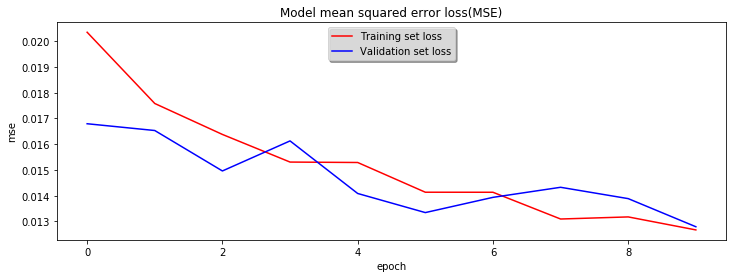

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(history.history['loss'], color='red', label='Training set loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation set loss')
plt.title('Model mean squared error loss(MSE)')
plt.ylabel('mse')
plt.xlabel('epoch')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')